# Tweaking A Model 

In this Notebook, we focus on a number of tweaks that we can apply to our model to yield better results. <br>

-Vocabulary Size <br>
-Input Length ( Where to truncate ?) <br>
-Padding (Before or After) <br>
-Number of Embedding dimesions <br>
-Flatten Vs Global Average Pooling 

# Setup

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The Dataset

We shall be using a dataset containing Amazon and Yelp reviews

In [5]:
path = tf.keras.utils.get_file('reviews.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print (path)

/Users/apple/.keras/datasets/reviews.csv


In [6]:
# Read the csv file
dataset = pd.read_csv(path)

# Review the first few entries in the dataset
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


# Split Dataset into Training & Testing 

In [7]:
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Tokenization ( with Tweaks )

Initial Settings : <br><br>
vocab_size = 1000 <br>
embedding_dim = 16 <br>
max_length = 100 <br>
trunc_type='post' <br>
padding_type='post'

Will these tweaks have any significant effect on our model ?? 

In [8]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Train a Sentiment Model (with tweaks)

In [9]:
# We added a GlobalAveragePooling1D layer instead of Flatten 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 1593 samples, validate on 399 samples
Epoch 1/30
1593/1593 [==============================] - 1s 599us/sample - loss: 0.6919 - accuracy: 0.5355 - val_loss: 0.6972 - val_accuracy: 0.4110
Epoch 2/30
1593/1593 [==============================] - 0s 75us/sample - loss: 0.6890 - accuracy: 0.5229 - val_loss: 0.6979 - val_accuracy: 0.4135
Epoch 3/30
1593/1593 [==============================] - 0s 77us/sample - loss: 0.6858 - accuracy: 0.5468 - val_loss: 0.6956 - val_accuracy: 0.4336
Epoch 4/30
1593/1593 [==============================] - 0s 72us/sample - loss: 0.6797 - accuracy: 0.5756 - val_loss: 0.6882 - val_accuracy: 0.4937
Epoch 5/30
1593/1593 [==============================] - 0s 74us/sample - loss: 0.6710 - accuracy: 0.6133 - val_loss: 0.6792 - val_accuracy: 0.5514
Epoch 6/30
1593/1593 [==============================] - 0s 73us/sample - loss: 0.6581 - accuracy: 0.6736 - val_loss: 0.6708 - val_accuracy: 0.5589
Epoch 7/30
1593/1593 [==============================] - 0s 71us/sample

# Visualize the training graph

We use the code below to visualize the training and validation accuracy while we try out different tweaks to the hyperparameters and model.

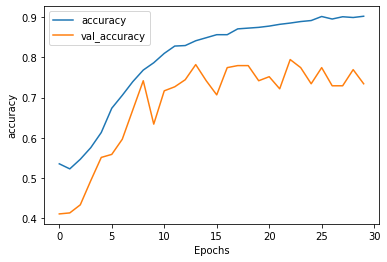

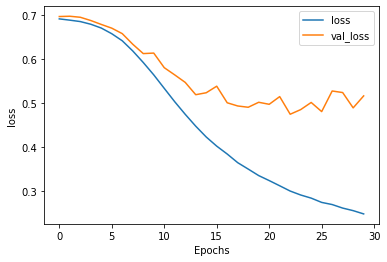

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Get files for visualizing the network

The code below will download two files for visualizing how your network "sees" the sentiment related to each word. Head to http://projector.tensorflow.org/ and load these files, then click the checkbox to "sphereize" the data.

Note: You may run into errors with the projection if your vocab_size earlier was larger than the actual number of words in the vocabulary, in which case you'll need to decrease this variable and re-train in order to visualize.

In [12]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [13]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# Predicting Sentiment in New Reviews

In [23]:
# Use the model to predict a review   
fake_reviews = ['I love this version of the PS4',
                'This game belongs in the trash',
                'Very bad Service',
                'Excellent Service',
                'It really upset me',
                'Great Service',
                'I had a wonderful experience',
                'This is exactly what i wanted',
                'Very difficult to Understand',
                'I hate Jollof Rice', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head',
                'I hate this book']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nSENTIMENT ANALYSIS OF SOME RANDOM REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this version of the PS4', 'This game belongs in the trash', 'Very bad Service', 'Excellent Service', 'It really upset me', 'Great Service', 'I had a wonderful experience', 'This is exactly what i wanted', 'Very difficult to Understand', 'I hate Jollof Rice', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head', 'I hate this book']

SENTIMENT ANALYSIS OF SOME RANDOM REVIEWS!

I love this version of the PS4
[0.9127534]


This game belongs in the trash
[0.3777342]


Very bad Service
[0.08951107]


Excellent Service
[0.9033774]


It really upset me
[0.31489146]


Great Service
[0.9532703]


I had a wonderful experience
[0.6235594]


This is exactly what i wanted
[0.48269957]


Very difficult to Understand
[0.18307616]


I hate Jollof Rice
[0.155900